In [2]:
import os
import numpy as np

import torch

from sfno.pipeline import *
from sfno.datasets import *
from sfno.losses import SobolevLoss

from sfno.fno3d import FNO3d
from sfno.visualizations import plot_contour_trajectory
from torch.utils.data import DataLoader

from fno.utils import get_seed
get_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




The following code snippets have been run.

        os.environ['PYTHONHASHSEED'] = str(42)
        numpy.random.seed(42)
        torch.manual_seed(42)
        torch.cuda.manual_seed(42)
        
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.cuda.manual_seed_all(42)


In [38]:
TRAIN_PATH = VALID_PATH = os.path.join(DATA_PATH, "McWilliams2d_fp32_64x64_N1152_v1e-3_T100.pt")

Ntrain = 1024
Ntest = 32

batch_size = 4

epochs = 10
learning_rate = 1e-3

n = 64
T_start = 10
T = 10


modes = 32
modes_t = 5
width = 10


model_name = (
    "fno3d_mcwiliams2d_v1e3_N"
    + str(Ntrain)
    + "_ep"
    + str(epochs)
    + "_m"
    + str(modes)
    + "_w"
    + str(width)
    + ".pt"
)
path_model = os.path.join(MODEL_PATH, model_name)
print(model_name)


fno3d_mcwiliams2d_v1e3_N1024_ep10_m32_w10.pt


In [17]:
train_dataset = BochnerDatasetFixed(
    datapath=TRAIN_PATH,
    fields=["vorticity"],
    n_samples=Ntrain,
    inp_normalizer=True,
    normalize_space_only=False,
    out_normalizer=True,
    steps=T,
    out_steps=T,
    T_start=T_start,
)
test_dataset = BochnerDatasetFixed(
    datapath=VALID_PATH,
    fields=["vorticity"],
    n_samples=Ntest,
    steps=T,
    out_steps=T,
    inp_normalizer=train_dataset.inp_normalizer,
    out_normalizer=train_dataset.out_normalizer,
    train=False,
    T_start=T_start,
)

In [18]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [26]:
torch.cuda.empty_cache()
model = FNO3d(modes, modes, modes_t, width, input_channel=T).to(device)

print(get_num_params(model))

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    div_factor=1e4,
    final_div_factor=1e3,
    steps_per_epoch=len(train_loader),
    epochs=epochs,
)

l2diff = SobolevLoss(n_grid=n, norm_order=0, time_average=True, relative=True)


16386997


In [27]:
for ep in range(epochs):
    model.train()
    train_l2 = 0

    with tqdm(total=len(train_loader)) as pbar:
        for i, data in enumerate(train_loader):
            l2 = train_batch_ns(
                model,
                l2diff,
                data,
                optimizer,
                device,
                normalizer=train_dataset.out_normalizer,
            )
            train_l2 += l2.item()
            is_epoch_scheduler = any(s in str(scheduler.__class__) for s in EPOCH_SCHEDULERS)
            if not is_epoch_scheduler:
                scheduler.step()

            if i % 4 == 0:
                pbar.set_description(f"train rel L2: {l2.item():.4e}")
                pbar.update(4)
    test_l2_min = 1e4
    test_l2 = eval_epoch_ns(
        model, l2diff, test_loader, device, normalizer=train_dataset.out_normalizer
    )

    if test_l2 < test_l2_min:
        torch.save(model.state_dict(), path_model)
        test_l2_min = test_l2

    print(
        f"\nEpoch {ep+1} | ",
        f"Train L2: {train_l2/len(train_loader):.5e} |",
        f"Test  L2: {test_l2:.5e}\n",
    )

  0%|          | 0/256 [00:00<?, ?it/s]

train rel L2: 3.0047e-01: 100%|██████████| 256/256 [00:09<00:00, 27.30it/s]



Epoch 1 |  Train L2: 3.12667e-01 | Test  L2: 2.94744e-01



train rel L2: 2.1028e-01: 100%|██████████| 256/256 [00:09<00:00, 28.19it/s]



Epoch 2 |  Train L2: 2.45643e-01 | Test  L2: 2.18155e-01



train rel L2: 1.9983e-01: 100%|██████████| 256/256 [00:09<00:00, 28.11it/s]



Epoch 3 |  Train L2: 2.09107e-01 | Test  L2: 2.04649e-01



train rel L2: 1.9697e-01: 100%|██████████| 256/256 [00:09<00:00, 28.25it/s]



Epoch 4 |  Train L2: 1.97012e-01 | Test  L2: 1.93751e-01



train rel L2: 1.8230e-01: 100%|██████████| 256/256 [00:09<00:00, 28.16it/s]



Epoch 5 |  Train L2: 1.86737e-01 | Test  L2: 1.84471e-01



train rel L2: 1.7315e-01: 100%|██████████| 256/256 [00:09<00:00, 28.18it/s]



Epoch 6 |  Train L2: 1.76830e-01 | Test  L2: 1.74913e-01



train rel L2: 1.7047e-01: 100%|██████████| 256/256 [00:09<00:00, 28.03it/s]



Epoch 7 |  Train L2: 1.66850e-01 | Test  L2: 1.65571e-01



train rel L2: 1.5154e-01: 100%|██████████| 256/256 [00:09<00:00, 28.07it/s]



Epoch 8 |  Train L2: 1.57978e-01 | Test  L2: 1.59280e-01



train rel L2: 1.5464e-01: 100%|██████████| 256/256 [00:09<00:00, 28.02it/s]



Epoch 9 |  Train L2: 1.52511e-01 | Test  L2: 1.56458e-01



train rel L2: 1.5102e-01: 100%|██████████| 256/256 [00:09<00:00, 27.98it/s]



Epoch 10 |  Train L2: 1.50378e-01 | Test  L2: 1.56082e-01



In [28]:
torch.cuda.empty_cache()
model = FNO3d(modes, modes, modes_t, width, input_channel=T).to(device)
model.load_state_dict(torch.load(path_model))
normalizer = train_dataset.out_normalizer['vorticity']
preds = []
gt_solns = []
test_l2_all = []
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
loss_func = SobolevLoss(n_grid=n, norm_order=0, time_average=True, relative=True)

with torch.no_grad():
    model.eval()
    for i, (x, y) in enumerate(test_loader):
        x, y = x['vorticity'].to(device), y['vorticity'].to(device)

        out, _ = model(x)
        out = normalizer.inverse_transform(out)
        y = normalizer.inverse_transform(y)

        preds.append(out)
        gt_solns.append(y)

        test_l2 = loss_func(out, y).item()
        test_l2_all.append(test_l2)

preds = torch.cat(preds, dim=0)
gt_solns = torch.cat(gt_solns, dim=0)
print(np.mean(test_l2_all))

0.1560824797488749


In [31]:
(10-T_start)/100

0.0

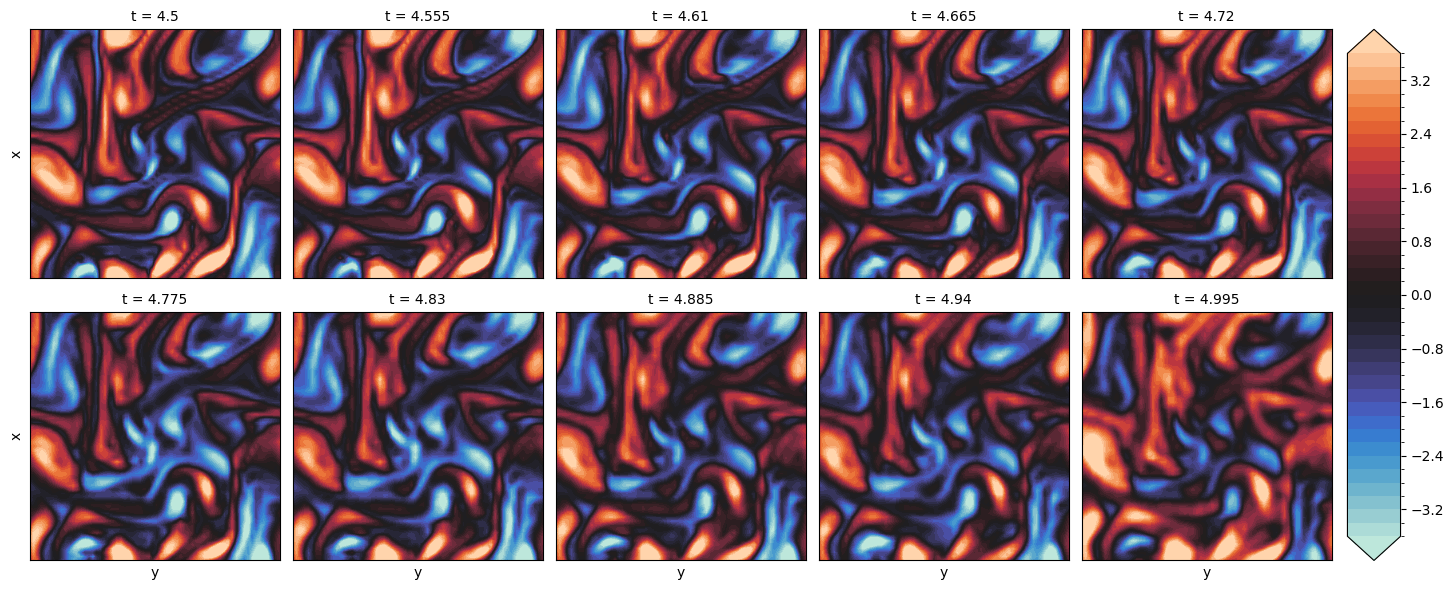

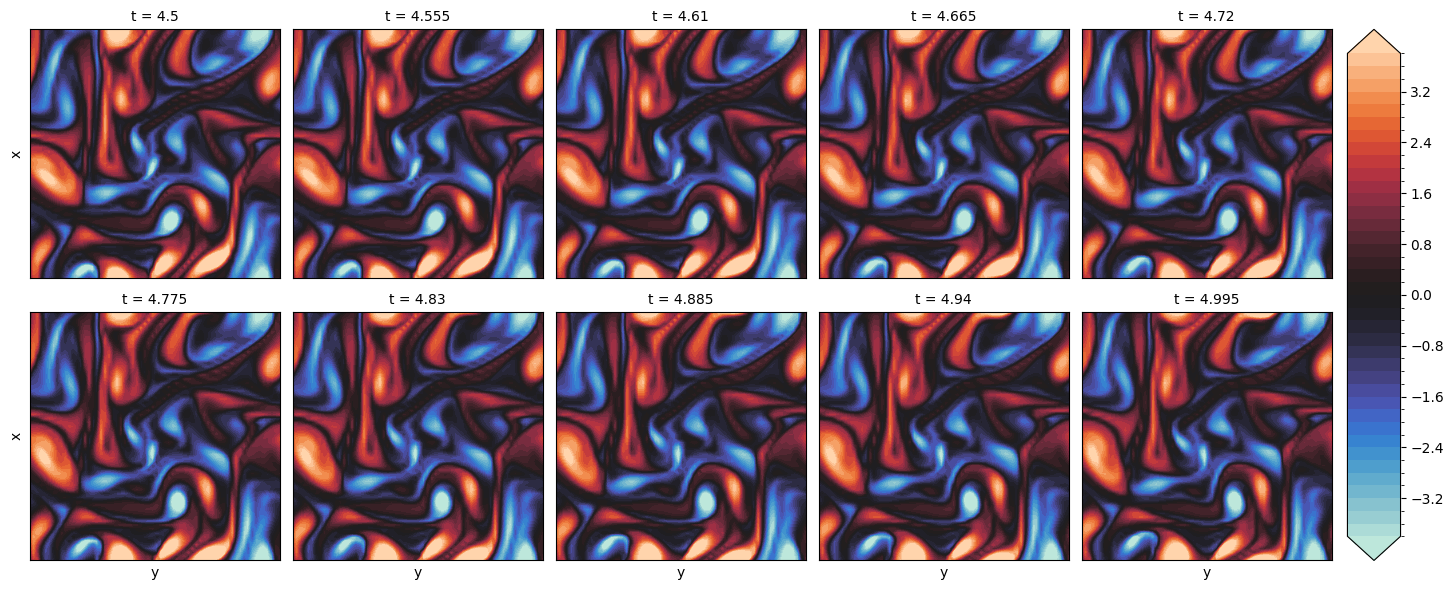

In [35]:
idx = np.random.randint(0, Ntest)
plot_contour_trajectory(preds[idx], num_snapshots=10, contourf=False, levels=40, T_start=4.5, dt=(10-4.5)/100)
plot_contour_trajectory(gt_solns[idx], num_snapshots=10, contourf=False, levels=40, T_start=4.5, dt=(10-4.5)/100)